# Extending existing synthesis objects

Once you are familiar with the existing synthesis objects included in `plenoptic`, you may wish to change some aspect of their function. For example, you may wish to change how the `po.synth.MADCompetition` initializes the MAD image or alter the objective function of `po.synth.Metamer`. While you could certainly start from scratch or copy the source code of the object and alter them directly, an easier way to do so is to create a new sub-class: an object that inherits the synthesis object you wish to modify and over-writes some of its existing methods.

For example, you could create a version of `po.synth.MADCompetition` that starts with a different natural image (rather than with `image` argument plus normally-distributed noise) by creating the following object:

In [2]:
import warnings

import matplotlib.pyplot as plt
import torch
from torch import Tensor

import plenoptic as po

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

%load_ext autoreload
%autoreload 2

In [3]:
class MADCompetitionVariant(po.synth.MADCompetition):
    """Initialize MADCompetition with an image instead!"""

    def setup(
        self,
        initial_image: Tensor | None = None,
        optimizer: torch.optim.Optimizer | None = None,
        optimizer_kwargs: dict | None = None,
        scheduler: torch.optim.lr_scheduler.LRScheduler | None = None,
        scheduler_kwargs: dict | None = None,
    ):
        mad_image = initial_image.clamp(*self.allowed_range)
        self._initial_image = mad_image.clone()
        mad_image.requires_grad_()
        self._mad_image = mad_image
        self._reference_metric_target = self.reference_metric(
            self.image, self.mad_image
        ).item()
        self._reference_metric_loss.append(self._reference_metric_target)
        self._optimized_metric_loss.append(
            self.optimized_metric(self.image, self.mad_image).item()
        )
        # initialize the optimizer
        self._initialize_optimizer(optimizer, self.mad_image, optimizer_kwargs)
        # and scheduler
        self._initialize_scheduler(scheduler, self.optimizer, scheduler_kwargs)
        # reset _loaded, if everything ran successfully
        self._loaded = False

We can then interact with this new object in the same way as the original `MADCompetition` object, the only difference being how `setup()` is called:

In [4]:
image = po.data.einstein()
curie = po.data.curie()

new_mad = MADCompetitionVariant(
    image, po.metric.mse, lambda *args: 1 - po.metric.ssim(*args), "min"
)
new_mad.setup(curie)
old_mad = po.synth.MADCompetition(
    image, po.metric.mse, lambda *args: 1 - po.metric.ssim(*args), "min"
)
old_mad.setup(0.1)

/home/billbrod/miniforge3/envs/plenoptic/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/billbrod/Documents/plenoptic-org/plenoptic/src/plenoptic/synthesize/mad_competition.py:151: UserWarning: Since metric_tradeoff_lamda was None, automatically set to 0.10000000149011612 to roughly balance metrics.
  warnings.warn(
/home/billbrod/Documents/plenoptic-org/plenoptic/src/plenoptic/synthesize/mad_competition.py:151: UserWarning: Since metric_tradeoff_lamda was None, automatically set to 0.10000000149011612 to roughly balance metrics.
  warnings.warn(


We can see below that the two versions have the same `image` whose representation they're trying to match, but very different initial images.

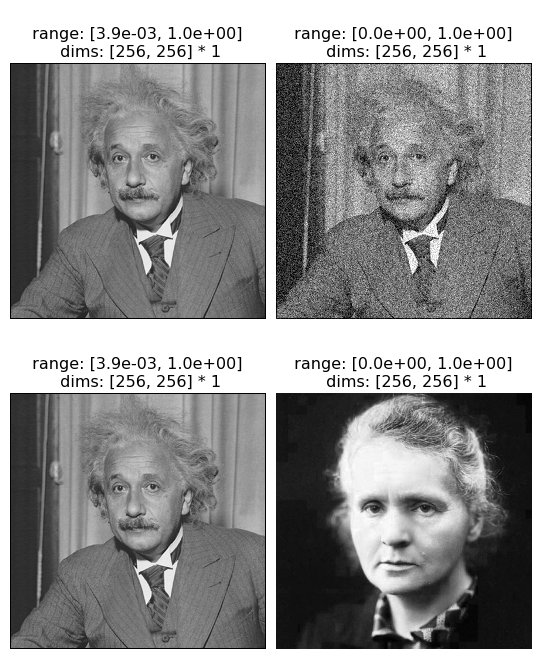

In [6]:
po.imshow(
    [
        old_mad.image,
        old_mad.initial_image,
        new_mad.image,
        new_mad.initial_image,
    ],
    col_wrap=2,
);

We call synthesize in the same way and can even make use of the original `plot_synthesis_status` function to see what synthesis looks like

  0%|          | 0/100 [00:00<?, ?it/s]

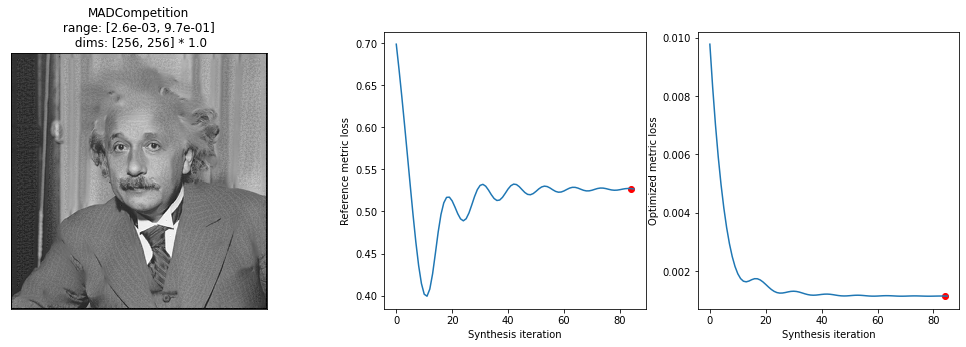

In [5]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1)
    # range, which will happen briefly during synthesis.
    warnings.simplefilter("ignore")
    old_mad.synthesize(store_progress=True)
po.synth.mad_competition.plot_synthesis_status(
    old_mad, included_plots=["display_mad_image", "plot_loss"]
)

  0%|          | 0/100 [00:00<?, ?it/s]

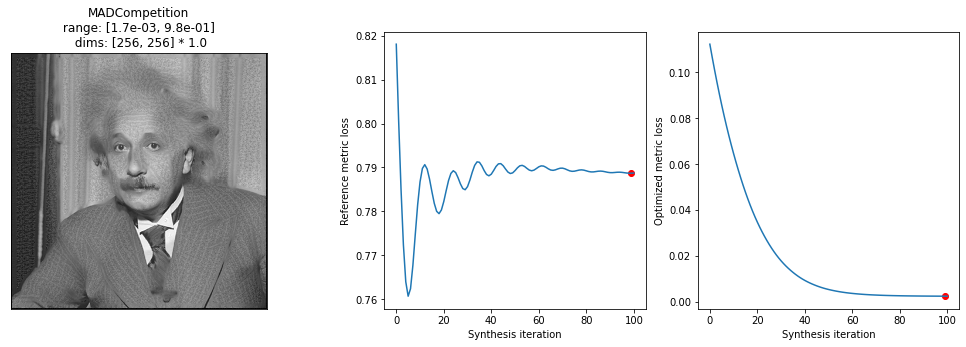

In [6]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1)
    # range, which will happen briefly during synthesis.
    warnings.simplefilter("ignore")
    new_mad.synthesize(store_progress=True)
po.synth.mad_competition.plot_synthesis_status(
    new_mad, included_plots=["display_mad_image", "plot_loss"]
)

For version initialized with the image of Marie Curie, let's also examine the metamer shortly after synthesis started, since the final version doesn't look that different:

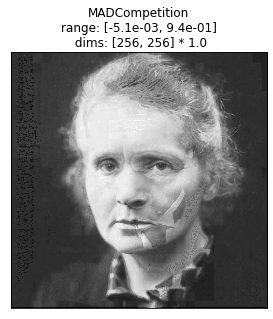

In [7]:
po.synth.mad_competition.display_mad_image(new_mad, iteration=10)

See the [documentation](../synthesis.rst) for more description of how the synthesis objects are structured to get ideas for how else to modify them, but some good methods to over-write include (note that not every object uses each of these methods): `_initialize`, `_check_convergence`, and `objective_function` (for more serious changes to initialization, probably better to start with `_initialize`). For a more serious change, you could also overwrite `synthesis` and `_optimizer_step` (and possibly `_closure`) to really change how synthesis works. See `po.synth.MetamerCTF` for an example of how to do this.